<span style="color: blue; font-size: 20px; font-weight: bold;">Комментарий ревьюера</span>

<span style="color: blue">Привет, Алексей! Это снова Павел Григорьев, и я буду проверять этот проект.<br>Моя основная цель - не указать на совершённые тобой ошибки, а поделиться своим опытом и помочь тебе совершенствоваться как профессионалу.<br>Спасибо за проделанную работу!</span>
<details>
	<summary><u>Инструкция по организационным моментам (кликабельно)</u>⤵</summary>
<span style="color: blue">Я буду использовать различные цвета, чтобы было удобнее воспринимать мои комментарии:</span>


---


<span style="color: blue">синий текст - просто текст комментария</span>

<span style="color: green">✔️ и зеленый текст - все отлично</span>

<span style="color: orange">⚠️ и оранжевый текст - сделано все правильно, однако есть рекомендации, на что стоит обратить внимание</span>

<span style="color: red">❌ и красный текст - есть недочеты</span>


</details>    
</br>
<span style="color: blue">Пожалуйста, не удаляй мои комментарии в случае возврата работы, так будет проще разобраться, какие были недочеты, а также сразу увидеть исправленное.</span>

<span style="color: blue">Ответы на мои комментарии лучше тоже помечать.<br>
Например: </span><br><span style="color: purple; font-weight: bold">Комментарий студента</span>

<span style="color: blue; font-weight: bold;">Давай смотреть, что получилось!</span>


<span style="color: purple; font-weight: bold">Комментарий студента</span>:<br />
Привет, Павел. Спасибо за твой фидбэк.

# Модель для определения возрастной категории пользователей

- Автор: Ильин А.В.
- Дата: 04.01.2026

**Содержимое проекта**

1. [Цели и задачи проекта](#section1)
2. [Подготовка среды и библиотек](#section2)
3. [Исследовательский анализ данных](#section3)
4. [Предобработка данных](#section4)
5. [Обучение и оценка базовой модели](#section5)
6. [Создание и отбор признаков](#section6)
7. [Подбор гиперпараметров моделей](#section7)
8. [Подготовка артефактов модели для внедрения](#section8)
9. [Выводы о результатах работы](#section9)

<a class='anchor' id="section1"></a>
## Цели и задачи проекта

Разработать модель для определения возрастной категории пользователей. В качестве основной метрики будем использовать F1.

### Описание данных

Данные состоят из шести датасетов.

- `/datasets/ds_s13_users.csv` — информация о возрастной категории пользователя;
- `/datasets/ds_s13_visits.csv` — информация об активности пользователей разных сайтов;
- `/datasets/ads_activity.csv` — информация об активность взаимодействия пользователя с рекламными объявлениями;
- `/datasets/surf_depth.csv` — информация характеризующая глубину перехода пользователя по сайтам во время одной сессии;
- `/datasets/primary_device.csv` — информация о типе основного устройства пользователя для выхода в Интернет;
- `/datasets/cloud_usage.csv` — информация об использование облачных технологий.

### Описание датасета `ds_s13_users`

- `user_id` — уникальный идентификатор пользователя;
- `age_category` — возрастная категория пользователя.

### Описание датасета `ds_s13_visits`

- `user_id` — уникальный идентификатор пользователя;
- `date` — дата посещения сайта;
- `daytime` — анонимизированное время посещения сайта;
- `session_id` — уникальный идентификатор сессии;
- `website_category` — анонимизированная категория сайта.

### Описание датасета `ads_activity`

- `user_id` — уникальный идентификатор пользователя;
- `ads_activity` — характеристика CTR.

### Описание датасета `surf_depth`

- `user_id` — уникальный идентификатор пользователя;
- `surf_depth` — категориальная переменная, характеризующая глубину перехода пользователя по сайтам во время одной сессии.

### Описание датасета `primary_device`

- `user_id` — уникальный идентификатор пользователя;
- `primary_device` — информация о типе основного устройства пользователя для выхода в Интернет.

### Описание датасета `cloud_usage`

- `user_id` — уникальный идентификатор пользователя;
- `cloud_usage` — `True` означает, что пользователь обращается к облачным ресурсам.

## Подготовка среды и библиотек

Установим необходимые библиотеки.

In [1]:
!pip install -q phik
!pip install -q scikit-learn==1.6.1
!pip install -q joblib 

Импортируем библиотеки

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import (
    make_scorer,
    f1_score,
    precision_score,
    recall_score,
    classification_report
)
from sklearn.model_selection import (
    cross_validate,
    cross_val_score,
    GridSearchCV,
    train_test_split,
    StratifiedKFold
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    OneHotEncoder,
    StandardScaler,
    TargetEncoder    
)
from sklearn.svm import SVC

from phik import phik_matrix

import joblib

from IPython.display import display

<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'> Хорошее оформление импортов! \
Импорты собраны в одной ячейке, разделены на функциональные группы пустой строкой.</font>

Сделаем необходимые настройки отображения

In [3]:
# Отображать все столбцы
pd.set_option('display.max_columns', None)

# Устанавливаем опцию для отображения всех содержимого в ячейках
pd.set_option('display.max_colwidth', None)

pd.set_option('display.float_format', '{:.6f}'.format)

Пропишем константы

In [4]:
RANDOM_STATE = 42

Выгрузим данные в переменные.

In [5]:
ds_s13_users_df = pd.read_csv('https://code.s3.yandex.net/datasets/ds_s13_users.csv')
ds_s13_visits_df = pd.read_csv('https://code.s3.yandex.net/datasets/ds_s13_visits.csv')
ads_activity_df = pd.read_csv('https://code.s3.yandex.net/datasets/ads_activity.csv')
surf_depth_df = pd.read_csv('https://code.s3.yandex.net/datasets/surf_depth.csv')
primary_device_df = pd.read_csv('https://code.s3.yandex.net/datasets/primary_device.csv')
cloud_usage_df = pd.read_csv('https://code.s3.yandex.net/datasets/cloud_usage.csv')

In [6]:
df_data = {
    'ds_s13_users_df': ds_s13_users_df,
    'ds_s13_visits_df': ds_s13_visits_df,
    'ads_activity_df': ads_activity_df,
    'surf_depth_df': surf_depth_df,
    'primary_device_df': primary_device_df,
    'cloud_usage_df': cloud_usage_df,
}

Посмотрим на данные датафреймов.

In [7]:
for name, data in df_data.items():
    print(f'Данные датафрейма {name}')
    data.info()
    display(data.head())
    print(50 * '-')
    print()

Данные датафрейма ds_s13_users_df
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5913 entries, 0 to 5912
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       5913 non-null   object
 1   age_category  5913 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 92.5+ KB


,user_id,age_category
0,f545-8c95aefe8d3e5548a689-a5b2fd39,4
1,cb48-5a0d6cde4d86ae10637e-c8ceb6ed,2
2,678b-614cd47d854b9d591db2-000b2e50,0
3,4ac0-dad169100b4a29b20818-b26ae7c5,4
4,f19b-9ac21ca973b41ecfa8c3-6a58191d,0


--------------------------------------------------

Данные датафрейма ds_s13_visits_df
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1065745 entries, 0 to 1065744
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   date              1065745 non-null  object
 1   daytime           1065745 non-null  object
 2   session_id        1065745 non-null  object
 3   user_id           1065745 non-null  object
 4   website_category  1065745 non-null  object
dtypes: object(5)
memory usage: 40.7+ MB


,date,daytime,session_id,user_id,website_category
0,2025-11-01,вечер,066e4e02-8c1f-45eb-a50f-178659abe698,0010-5cf8f6b38a7b6c70a021-009dbcda,Category 17
1,2025-11-01,вечер,0bce1749-3376-439c-9a22-f8ffbba00e9a,0010-5cf8f6b38a7b6c70a021-009dbcda,Category 19
2,2025-11-01,вечер,3445d8c4-221d-4d88-bb6a-a2939fe3c610,0010-5cf8f6b38a7b6c70a021-009dbcda,Category 18
3,2025-11-01,вечер,3bf97286-1d91-4aaa-af4a-ed58eceb8cd2,0010-5cf8f6b38a7b6c70a021-009dbcda,Category 20
4,2025-11-01,вечер,40e22712-3cad-410d-a9f0-13bd8f6911c0,0010-5cf8f6b38a7b6c70a021-009dbcda,Category 05


--------------------------------------------------

Данные датафрейма ads_activity_df
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5826 entries, 0 to 5825
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       5826 non-null   object
 1   ads_activity  5826 non-null   object
dtypes: object(2)
memory usage: 91.2+ KB


,user_id,ads_activity
0,e318-d8e69c86b543a5fb927c-c36fb6e6,очень часто
1,35cd-a972339dec534f49332c-a8b6d383,редко
2,f7e6-3b29cf9cb7ed4bb00d8f-81534360,очень редко
3,5186-e25a37549e50f45b2b43-178eaabe,умеренно
4,febd-077f277466253ee04ef6-42656680,умеренно


--------------------------------------------------

Данные датафрейма surf_depth_df
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5715 entries, 0 to 5714
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     5715 non-null   object
 1   surf_depth  5715 non-null   object
dtypes: object(2)
memory usage: 89.4+ KB


,user_id,surf_depth
0,f238-0c4c1e787cce311541b7-736925a0,поверхностно
1,9030-1b562ad80182b6dc27f1-ce811740,глубоко
2,22e0-7c6cadcc45e246b8688d-c43c9b23,поверхностно
3,9d7f-a19f10756378940a49b5-5d03e1ef,поверхностно
4,4233-bb5ae4b09827e5497094-1a4956af,глубоко


--------------------------------------------------

Данные датафрейма primary_device_df
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5669 entries, 0 to 5668
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   user_id         5669 non-null   object
 1   primary_device  5669 non-null   object
dtypes: object(2)
memory usage: 88.7+ KB


,user_id,primary_device
0,d602-ec060db7597a6b8cd4e7-aa625896,смартфон
1,9204-9558455be649d4e77945-b5e25d62,ПК
2,5eea-22babd6a9474b43b9d0b-a39a4cf2,ноутбук
3,c142-0296948e8d08e417de10-2da9523c,смартфон
4,abec-bb4092da51eb2233a928-e44ba074,ПК


--------------------------------------------------

Данные датафрейма cloud_usage_df
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5680 entries, 0 to 5679
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      5680 non-null   object
 1   cloud_usage  5680 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 50.0+ KB


,user_id,cloud_usage
0,a1e4-91c8a52eb855595e653f-298ce305,False
1,db9a-7b8e9e94448b7fcb19b6-4edca15f,False
2,0d55-9ad768879e9b08ca7ff9-843f76c7,True
3,4baa-43285d10a6d3cc969f2a-b21881d1,False
4,b8cd-cbb2411db005115ca64d-32700c62,False


--------------------------------------------------



<font color='blue'><b>Комментарий ревьюера: </b></font> ⚠️\
<font color='darkorange'> Метод info выведет информацию и без print, print, в данном случае, печатает только слово None в аутпутах.
</font>

На основе предварительного анализа данных можно сказать, что пропуски отсутствуют во всех датафреймах. Типы данных корректные. Названия столбцов не требуют корректировки.

<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'>Данные загружены корректно, первичный осмотр проведен.</font>

## Исследовательский анализ данных

### Анализ дубликатов

Проверим данные на наличие дубликатов.

In [8]:
for name, data in df_data.items():
    print(f'Количество дубликатов в датафрейме {name}: {data.duplicated().sum()}')

Количество дубликатов в датафрейме ds_s13_users_df: 87
Количество дубликатов в датафрейме ds_s13_visits_df: 15750
Количество дубликатов в датафрейме ads_activity_df: 233
Количество дубликатов в датафрейме surf_depth_df: 0
Количество дубликатов в датафрейме primary_device_df: 0
Количество дубликатов в датафрейме cloud_usage_df: 0


В датафремах `ds_s13_users_df`, `ds_s13_visits_df` и `ads_activity_df` были найдены дубликаты, удалим их.

In [9]:
for name, data in df_data.items():
    df_data[name] = data.drop_duplicates()
    print(f'Количество дубликатов в датафрейме {name}: {df_data[name].duplicated().sum()}')

Количество дубликатов в датафрейме ds_s13_users_df: 0
Количество дубликатов в датафрейме ds_s13_visits_df: 0
Количество дубликатов в датафрейме ads_activity_df: 0
Количество дубликатов в датафрейме surf_depth_df: 0
Количество дубликатов в датафрейме primary_device_df: 0
Количество дубликатов в датафрейме cloud_usage_df: 0


Проверим на уникальность значения в столбце `user_id` в каждом датафрейме.

In [10]:
for name, data in df_data.items():
    print(f'Количество дубликатов в столбце user_id в датафрейме {name}: {data["user_id"].duplicated().sum()}')

Количество дубликатов в столбце user_id в датафрейме ds_s13_users_df: 0
Количество дубликатов в столбце user_id в датафрейме ds_s13_visits_df: 1044169
Количество дубликатов в столбце user_id в датафрейме ads_activity_df: 0
Количество дубликатов в столбце user_id в датафрейме surf_depth_df: 0
Количество дубликатов в столбце user_id в датафрейме primary_device_df: 0
Количество дубликатов в столбце user_id в датафрейме cloud_usage_df: 0


В датафрейме `ds_s13_visits_df` остались дубли `user_id`, так как у одного пользователя могло быть несколько сессий.

<span style="color: blue; font-weight: bold">Комментарий ревьюера : </span> ✔️\
<span style="color: green"> 👍</span>

### Подготовка данных и создание общего датафрейма

Напишем функцию которая получает на вход 6 датасетов, делает необходимую обработку и группирует их в общий датафрейм.

In [11]:
def combine_data(ds_s13_users_df, ds_s13_visits_df, ads_activity_df, surf_depth_df, primary_device_df, cloud_usage_df):
    df_data = {
        'ds_s13_users_df': ds_s13_users_df,
        'ds_s13_visits_df': ds_s13_visits_df,
        'ads_activity_df': ads_activity_df,
        'surf_depth_df': surf_depth_df,
        'primary_device_df': primary_device_df,
        'cloud_usage_df': cloud_usage_df,
    }
    
    # группирует данные в датасете `ds_s13_visits` по `user_id`, оставив столбцы `daytime` и `website_category`
    # в которых назначается самое часто встречающееся значение для конкретного пользователя.
    # Также добавляет два столбца с количеством уникальных дней и количеством сессий у каждого пользователя.
    df_data['ds_s13_visits_df'] = df_data['ds_s13_visits_df'].groupby('user_id').agg({
        'daytime': lambda x: x.mode().iloc[0] if not x.mode().empty else None,
        'website_category': lambda x: x.mode().iloc[0] if not x.mode().empty else None,
        'date': ['nunique', 'count']
    }).reset_index()
    df_data['ds_s13_visits_df'].columns = ['user_id', 'daytime', 'website_category', 'unique_days', 'total_sessions']
    
    df_data['ds_s13_visits_df']['avg_sessions_per_day'] = round(
        (df_data['ds_s13_visits_df']['total_sessions'] / df_data['ds_s13_visits_df']['unique_days']), 3
    )
    
    # Удаляем столбцы total_sessions и unique_days.
    df_data['ds_s13_visits_df'] = df_data['ds_s13_visits_df'].drop(columns=['total_sessions', 'unique_days'])
    
    # Объединим данные в единый датафрейм по полю user_id, а затем удалим этот столбец, так как это техническая информация.
    df = df_data['ds_s13_users_df']
    for name, data in list(df_data.items()):
        if name != 'ds_s13_users_df':
            df = pd.merge(df, data, on='user_id', how='left')
            
    return df    

In [12]:
#df_data['ds_s13_visits_df'].head()

<font color='blue'><b>Комментарий ревьюера: </b></font> ⚠️\
<font color='darkorange'>Датафреймы лучше всегда ограничивать методами .head(), .tail(), sample(). Иначе в выводах ячейки записывается весь Датафрейм, хоть он и не выводится на экран полностью. Такие Аутпуты сильно перегружают тетрадку.</font>

In [13]:
df = combine_data(ds_s13_users_df, ds_s13_visits_df, ads_activity_df, surf_depth_df, primary_device_df, cloud_usage_df)

<font color='blue'><b>Комментарий ревьюера : </b></font> ✔️\
<font color='green'> Верно, при объединении таблиц нужно привязаться к уникальному `'user_id'`.</font>

In [14]:
df = df.drop(columns=['user_id'])

In [15]:
df.head()

,age_category,daytime,website_category,avg_sessions_per_day,ads_activity,surf_depth,primary_device,cloud_usage
0,4,день,Category 05,13.714000,NaN,глубоко,смартфон,False
1,2,вечер,Category 03,10.286000,умеренно,средне,смартфон,False
2,0,вечер,Category 12,7.286000,умеренно,средне,смартфон,False
3,4,день,Category 18,18.071000,редко,поверхностно,смартфон,True
4,0,вечер,Category 12,8.714000,очень редко,поверхностно,смартфон,True


### Анализ признаков

In [16]:
cat_features = df.select_dtypes(include=['object']).columns
num_features = df.select_dtypes(include=['int', 'float']).columns

# Удаляем age_Category из числовых признаков
num_features = num_features.drop(['age_category'], errors='ignore').tolist()

Проверим количество уникальных значений у категориальных признаков.

In [17]:
for column in cat_features:
    print(f"Уникальные значения в столбце {column}:", df[column].unique())

Уникальные значения в столбце daytime: ['день' 'вечер' 'утро']
Уникальные значения в столбце website_category: ['Category 05' 'Category 03' 'Category 12' 'Category 18' 'Category 14'
 'Category 08' 'Category 17' 'Category 13' 'Category 06' 'Category 04'
 'Category 19' 'Category 15' 'Category 07' 'Category 01' 'Category 10'
 'Category 02' 'Category 16' 'Category 09' 'Category 20' 'Category 11']
Уникальные значения в столбце ads_activity: [nan 'умеренно' 'редко' 'очень редко' 'очень часто' 'часто']
Уникальные значения в столбце surf_depth: ['глубоко' 'средне' 'поверхностно' nan]
Уникальные значения в столбце primary_device: ['смартфон' 'ноутбук' 'ПК' 'планшет' nan]
Уникальные значения в столбце cloud_usage: [False True nan]


Столбец `website_category` имеет больше 10 значений, поэтому при предобработке для него будем использовать TargetEncoding кодирование, для остальных столбцов OneHotEncoding кодирование.

Посмотрим на распределение целевой переменной.

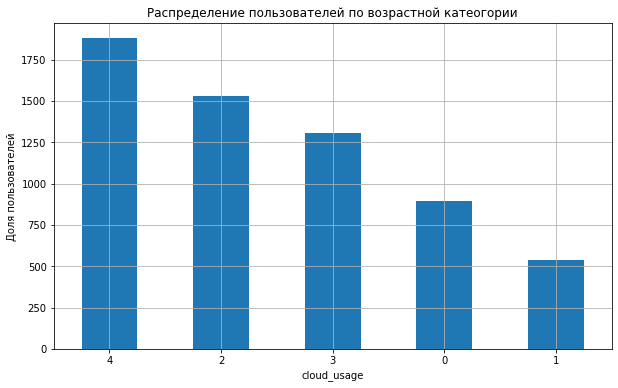

In [18]:
df['age_category'].value_counts().plot(
    kind='bar',
    rot=0,
    title=f'Распределение пользователей по возрастной катеогории',
    figsize=(10, 6)
)

plt.xlabel(column)
plt.ylabel('Доля пользователей')
plt.grid()
plt.show()

В распределении целевой переменной присутствует дисбаланс. Для усреднения метрик будем использовать macro усреднение.

Посмотрим на распределение категориальных признаков в разрезе возрастной категории.

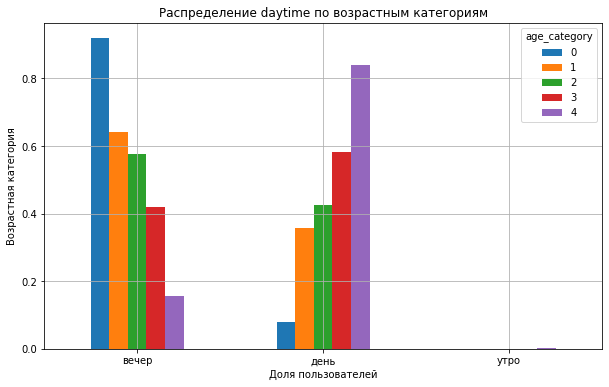

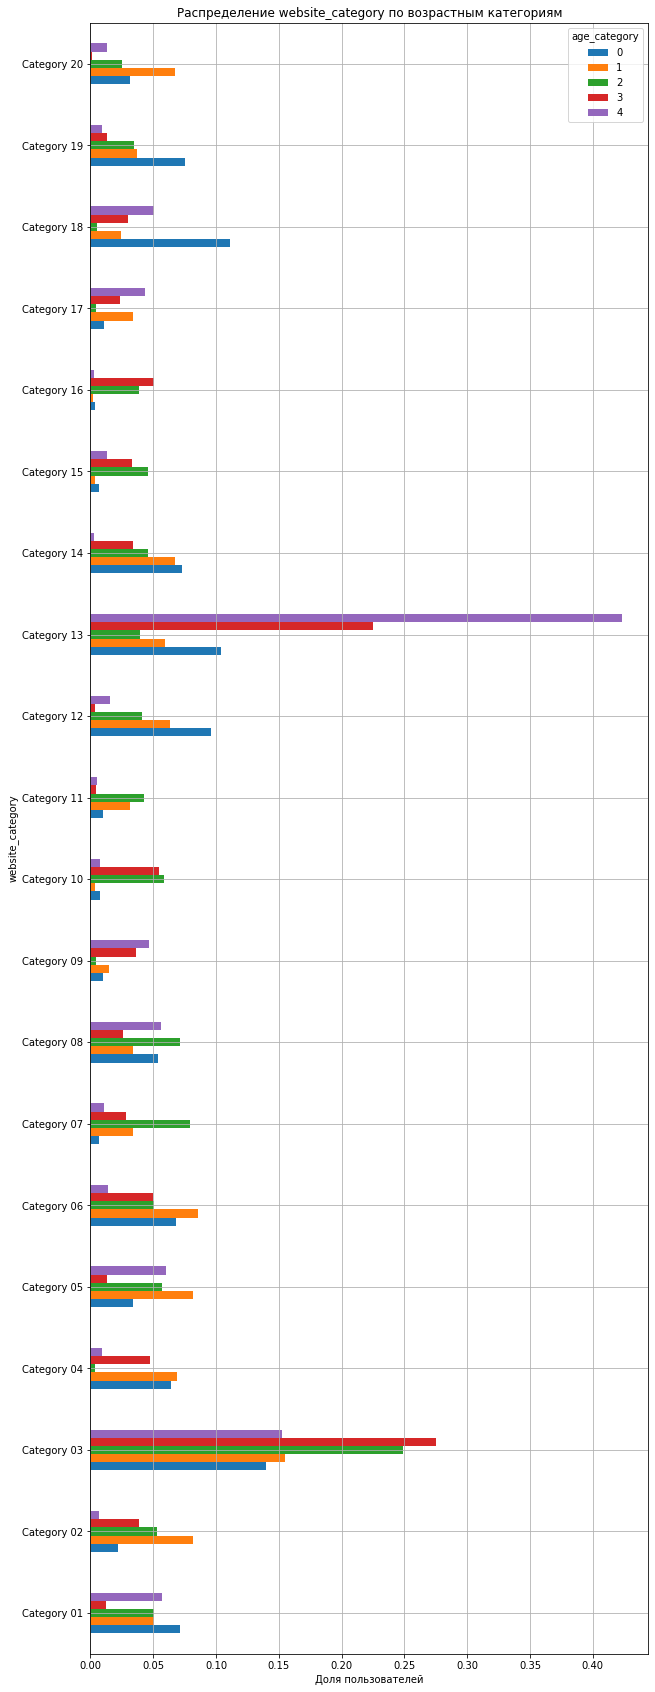

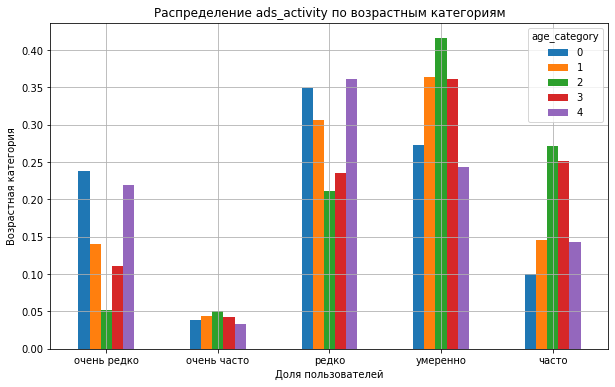

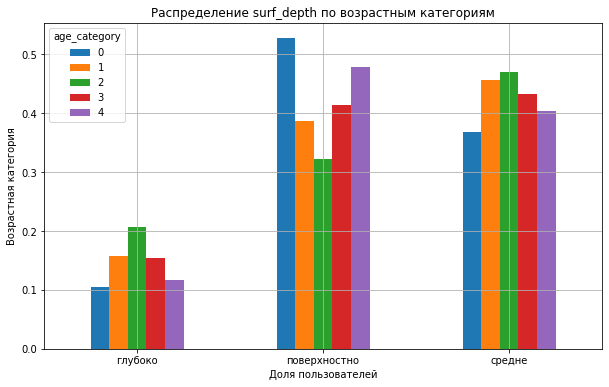

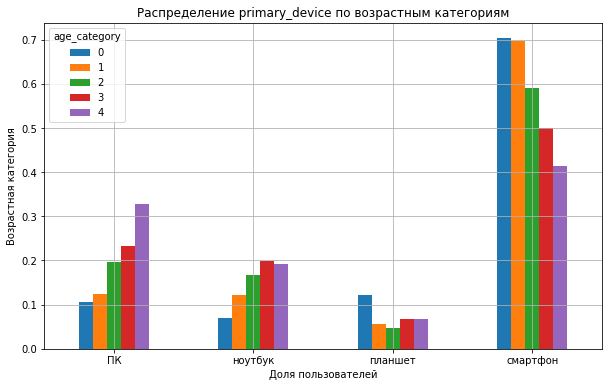

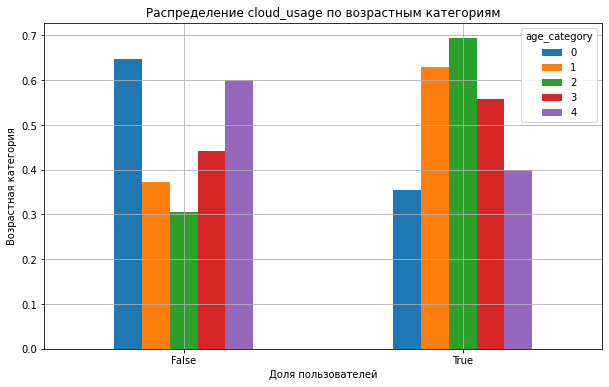

In [19]:
for column in cat_features:
    grouped = df.groupby('age_category')[column].value_counts(normalize=True).unstack(fill_value=0)
    grouped = grouped.T
    
    grouped.plot(
        kind=('barh' if column == 'website_category' else 'bar'),
        rot=0,
        title=f'Распределение {column} по возрастным категориям',
        figsize=((10, 30) if column == 'website_category' else (10, 6))
    )
    
    plt.xlabel('Доля пользователей')
    plt.ylabel(column if column == 'website_category' else 'Возрастная категория')
    plt.grid()
    plt.show()

Проанализируем числовые признаки.

In [20]:
def show_features_distribution (df, columns):
    for column in columns:
        print(f'Статистические данные параметра {column}')
        print()
        print(df[column].describe(percentiles=[0.25, 0.5, 0.75, 0.99]))
        print('')
        
        fig, axs = plt.subplots(1, 2, figsize=(15, 5))

        df.boxplot(column=column, vert=False, ax=axs[0])
        axs[0].set_title(f'Распределение параметра {column}')
        axs[0].set_xlabel('Размер, мм')

        sns.histplot(df[column], kde=True, bins=37, color='skyblue', edgecolor='black')
        axs[1].set_title(f'Распределение параметра {column}')
        axs[1].set_xlabel(column)
        axs[1].set_ylabel('Количество')
        axs[1].grid()

        plt.show()

        print('')

Статистические данные параметра avg_sessions_per_day

count   6146.000000
mean      13.056767
std        5.435670
min        7.143000
25%        9.000000
50%       12.071000
75%       15.500000
99%       31.714000
max       60.929000
Name: avg_sessions_per_day, dtype: float64



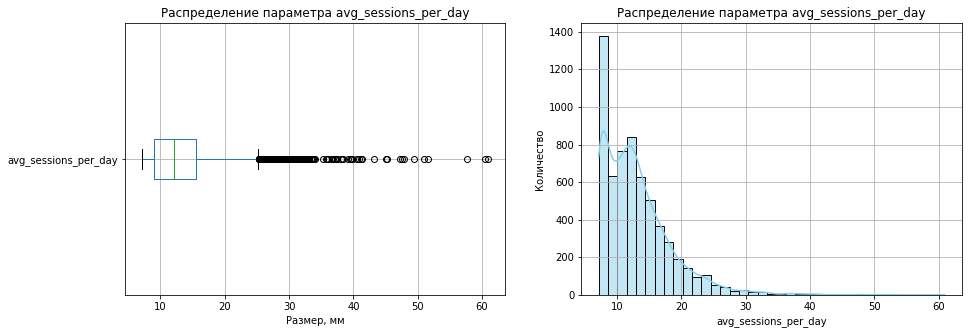

In [21]:
show_features_distribution(df, num_features)

Рапределение по признаку `avg_sessions_per_day` имеет правостороннюю скошенность, имеется всплеск в районе значений 12-13. Присутствуют выбросы справа.

Исходня из визуального анализа распределения можно уже сделать некоторые выводы:

- Пользователи до 18 пользуются интернетом в основном вечером, пользователи старше 56 лет днем.
- Пользователи старше 40 лет чаще заходят на сайты категории `Category 03` и `Category 13`. Пользователи в возрасте от 26 до 40 лет на сайты в категории `Category 13`.
- Большая часть пользователей младше 18 и старше 56 лет редко взаиодействуют с рекламой, в остальных возрастных категориях преобладают пользователи с умеренным взаимодействием с рекламой.
- Большая часть пользователей младше 18 и старше 56 лет имеют низкую глубину просмотра сайтов, у остальных категорий в основном средняя глубина просмотра.
- У всех возрастных категорий преобладающим устройством является смартфон.
- Большая часть пользователей младше 18 и старше 56 лет не пользуются облачными сервисами, у остальных категорий наоборот.

<font color='blue'><b>Комментарий ревьюера : </b></font> ✔️\
<font color='green'>Хорошая работа в части исследования данных: молодец, что используешь функции, а также применяешь подходящие для типов данных инструменты.</font>

### Корреляция между признаками

Построим матрицу корреялии между признаками.

In [22]:
corr_columns = np.concatenate((cat_features, ['age_category']))

In [23]:
# Вычисляем корреляционную матрицу с использованием phi_k
correlation_matrix = df[corr_columns].phik_matrix()
correlation_matrix

interval columns not set, guessing: ['age_category']


,daytime,website_category,ads_activity,surf_depth,primary_device,cloud_usage,age_category
daytime,1.000000,0.284384,0.025787,0.050571,0.094270,0.014951,0.430699
website_category,0.284384,1.000000,0.136974,0.121023,0.151797,0.152528,0.626433
ads_activity,0.025787,0.136974,1.000000,0.024500,0.000000,0.077720,0.373374
surf_depth,0.050571,0.121023,0.024500,1.000000,0.000000,0.020270,0.143816
primary_device,0.094270,0.151797,0.000000,0.000000,1.000000,0.000000,0.184037
cloud_usage,0.014951,0.152528,0.077720,0.020270,0.000000,1.000000,0.214836
age_category,0.430699,0.626433,0.373374,0.143816,0.184037,0.214836,1.000000


Визуализируем корреляцию с помощью тепловой карты.

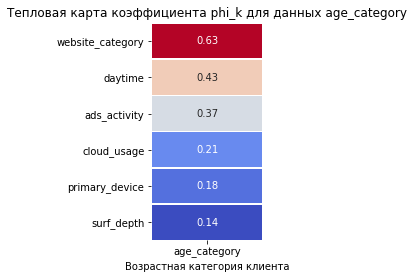

In [24]:
plt.figure(figsize=(2, 4))
data_heatmap = correlation_matrix.loc[correlation_matrix.index != 'age_category'][['age_category']].sort_values(by='age_category', ascending=False)
sns.heatmap(data_heatmap,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    linewidths=0.5,
    cbar=False
)
plt.title('Тепловая карта коэффициента phi_k для данных age_category')
plt.xlabel('Возрастная категория клиента')
plt.show()

Признаки `website_category`, `daytime` и `ads_activity` имею умеренную связь с целевой переменной. Наибольшая связь у `website_category` - 0.62. Признаки `cloud_usage`, `primary_device` и `surf_depth` имеют слабую связь с целевой переменной.

<font color='blue'><b>Комментарий ревьюера : </b></font> ✔️\
<font color='green'>Здорово,что применена `phik` для анализа и нелинейных зависимостей</font>

## Предобработка данных

Разделим данные на две части: для обучения (train) и тестовую (test) в соотношении 70:30.

In [25]:
X = df.drop(columns = ['age_category'])
y = df['age_category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y)

<span style="color: blue; font-weight: bold">Комментарий ревьюера : </span> ⚠️\
<span style="color: darkorange"> Не совсем понятно, зачем нам три выборки. Подбор параметров и оцеку моделей мы проводим кросс-валидацией.</span>

<span style="color: purple; font-weight: bold">Комментарий студента</span>:<br />
Поправил.

Проверим пропорции.

In [26]:
print("Размер выборки для обучения:", X_train.shape)
print("Размер тестовой выборки:", X_test.shape)

Размер выборки для обучения: (4302, 7)
Размер тестовой выборки: (1844, 7)


In [27]:
target_cat_features = ['website_category']
onehot_cat_features = cat_features.drop(target_cat_features, errors='ignore').tolist()

onehot_cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore')),
])

target_cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', TargetEncoder()),
])

num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler()),
])

cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [28]:
def build_preprocessor(onehot_cat_features, target_cat_features, num_features):
    preprocessor = ColumnTransformer(
        transformers=[
            ('onehot_cat', onehot_cat_pipeline, onehot_cat_features),
            ('target_cat', target_cat_pipeline, target_cat_features),
            ('num', num_pipeline, num_features)
        ]
    )
    return preprocessor

<span style="color: blue; font-weight: bold">Комментарий ревьюера : </span> ✔️\
<span style="color: green"> 👍</span>

In [29]:
# Создаем ColumnTransformer
preprocessor = build_preprocessor(onehot_cat_features, target_cat_features, num_features)

# Предварительный fit() для получения имён признаков
X_train_processed = preprocessor.fit_transform(X_train, y_train)
feature_names = preprocessor.get_feature_names_out()

<span style="color: blue; font-weight: bold">Комментарий ревьюера : </span>  ❌\
<span style="color: red"> Препроцессор (да и что бы то ни было), нельзя обучать на валидационных данных. Метод fit только для train выборки. </span>

<span style="color: purple; font-weight: bold">Комментарий студента</span>:<br />
Поправил.

In [30]:
class SafeFeatureSelector(BaseEstimator, TransformerMixin):
    """
    Безопасный селектор признаков, который проверяет границы массивов.
    Работает даже если количество признаков отличается в разных фолдах.
    """
    def __init__(self, selected_indices):
        self.selected_indices = selected_indices
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Проверяем, какие индексы существуют в текущем X
        valid_indices = [i for i in self.selected_indices if i < X.shape[1]]
        
        if len(valid_indices) > 0:
            return X[:, valid_indices]
        else:
            # Если ни один индекс не валиден, возвращаем нулевую матрицу
            return np.zeros((X.shape[0], 1))

In [31]:
def select_features(X_transformed, indices):
    return X_transformed[:, indices]

In [32]:
def build_pipeline(X, preprocessor, model, selected_features, scoring=None):
    feature_names_all = list(preprocessor.get_feature_names_out())
    selected_indices = [feature_names_all.index(f) for f in selected_features]

    selector = FunctionTransformer(
        select_features, 
        validate=False,
        kw_args={'indices': selected_indices}
    )

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('selector', selector),
        ('model', model)
    ])
    
    if scoring is None:
        scoring = {
            'f1_macro': make_scorer(f1_score, average='macro'),
            'precision_macro': make_scorer(precision_score, average='macro'),
            'recall_macro': make_scorer(recall_score, average='macro')
        }

    cv_results = cross_validate(
        pipeline,
        X=X,
        y=y_train, 
        scoring=scoring, 
        cv=cv_splitter, 
        n_jobs=-1,
        return_estimator=True
    )
    return pipeline, cv_results

<span style="color: blue; font-weight: bold">Комментарий ревьюера : </span> ✔️\
<span style="color: green">Верно, что применяется F1 macro.</span>

<span style="color: blue; font-weight: bold">Комментарий ревьюера : </span>  ❌\
<span style="color: red"> Кросс-валидация проводится на обучающих данных. </span>

<span style="color: purple; font-weight: bold">Комментарий студента</span>:<br />
Поправил.

## Обучение и оценка базовой модели

Обучим базовую модель DummyClassifier.

In [33]:
dummy = DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE)
dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)

In [34]:
print(f"F1: {f1_score(y_test, y_pred_dummy, average='macro'):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_dummy, average='macro', zero_division=0):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_dummy, average='macro'):.4f}")

F1: 0.0937
Precision: 0.0612
Recall: 0.2000


Обучим базовую модель LogisticRegression.

In [35]:
lr = LogisticRegression(max_iter=1000, class_weight='balanced', solver="lbfgs", penalty="l2", random_state=RANDOM_STATE)
lr_pipeline, lr_cv_results = build_pipeline(X_train, preprocessor, lr, feature_names)

Посмотрим на метрики модели LogisticRegression.

In [36]:
print(f"F1: {lr_cv_results['test_f1_macro'].mean():.4f}")
print(f"Precision: {lr_cv_results['test_precision_macro'].mean():.4f}")
print(f"Recall: {lr_cv_results['test_recall_macro'].mean():.4f}")

F1: 0.4826
Precision: 0.4818
Recall: 0.4991


<span style="color: blue; font-weight: bold">Комментарий ревьюера : </span> ✔️\
<span style="color: green"> 👍</span>

Обучим базовые модели SVC на разных ядрах.

In [37]:
svc_linear = SVC(
    class_weight='balanced',
    kernel='linear',
    random_state=RANDOM_STATE,
)

svc_poly = SVC(
    class_weight='balanced',
    kernel='poly',
    degree=3,
    coef0=1,
    random_state=RANDOM_STATE,
)

svc_rbf = SVC(
    class_weight='balanced',
    kernel='rbf',
    gamma='scale',
    random_state=RANDOM_STATE
)

svc_sigmoid = SVC(
    class_weight='balanced',
    kernel='sigmoid',
    coef0=1,
    gamma='scale',
    random_state=RANDOM_STATE
)

svc_scores = {}

_, svc_scores['linear'] = build_pipeline(X_train, preprocessor, svc_linear, feature_names)
_, svc_scores['poly'] = build_pipeline(X_train, preprocessor, svc_poly, feature_names)
_, svc_scores['rbf'] = build_pipeline(X_train, preprocessor, svc_rbf, feature_names)
_, svc_scores['sigmoid'] = build_pipeline(X_train, preprocessor, svc_sigmoid, feature_names)

Посмотрим на метрики SVC моделей.

In [38]:
for name, metrics in svc_scores.items():
    print(f"Ядро: {name}")
    print("Средние значения метрик:")
    print(f"F1: {metrics['test_f1_macro'].mean():.4f}")
    print(f"Precision: {metrics['test_precision_macro'].mean():.4f}")
    print(f"Recall: {metrics['test_recall_macro'].mean():.4f}")
    print("-" * 50)

Ядро: linear
Средние значения метрик:
F1: 0.4724
Precision: 0.4758
Recall: 0.4934
--------------------------------------------------
Ядро: poly
Средние значения метрик:
F1: 0.4833
Precision: 0.4808
Recall: 0.5006
--------------------------------------------------
Ядро: rbf
Средние значения метрик:
F1: 0.4685
Precision: 0.4675
Recall: 0.4911
--------------------------------------------------
Ядро: sigmoid
Средние значения метрик:
F1: 0.2581
Precision: 0.3464
Recall: 0.2781
--------------------------------------------------


Среди базовых моделей SVC модель с `linear` ядром показывает лучшие результаты, близкие к результатам модели LogisticRegression, но в целом результаты низкие.

<span style="color: blue; font-weight: bold">Комментарий ревьюера : </span> ✔️\
<span style="color: green"> 👍</span>

## Создание и отбор признаков

Напишем функцию для создания новых признаков. Возмем корень из признака `avg_sessions_per_day`, чтобы сжать большие значения в нем. Создадим признаки отражающие взаимодействие времени суток и активности и взаимодействие времени суток и категории сайта.

In [39]:
def create_enhanced_features(X):
    """
    Создаёт расширенный набор признаков
    """

    # Создаём копию датасета, чтобы не изменять исходный датасет
    X_enhanced = X.copy()

    # 1. Берем корень из avg_sessions_per_day
    X_enhanced['sqrt_avg_sessions'] = np.sqrt(X_enhanced['avg_sessions_per_day'])
    
    # 2. Взаимодействие времени суток и типа устройства
    X_enhanced["daytime_device"] = (X_enhanced["daytime"] + '_' + X_enhanced["primary_device"])
    
    # 3. # Мобильные облачные пользователи
    X_enhanced['mobile_cloud_user'] = ((X_enhanced['primary_device'] == 'смартфон') & 
                               (X_enhanced['cloud_usage'] == True)).astype(int)
    
    # 4. Активные пользователи рекламы
    active_ads = ['умеренно', 'часто', 'очень часто']
    X_enhanced['is_active_ads_user'] = X_enhanced['ads_activity'].isin(active_ads).astype(int)
    
    # 5. Категория сайта + активность рекламы (предварительно заполняем пропуски)
    X_enhanced['ads_activity_filled'] = X_enhanced['ads_activity'].fillna('неизвестно')
    X_enhanced['website_ads_interaction'] = X_enhanced['website_category'] + '_' + X_enhanced['ads_activity_filled']

    # Удаляем исходные признаки, которые заменили производными
    columns_to_drop = [
        "avg_sessions_per_day",
        "ads_activity_filled"
    ]

    # Удаляем указанные колонки
    X_enhanced = X_enhanced.drop(columns=columns_to_drop)

    return X_enhanced

# Создаем расширенный набор признаков
X_train_enhanced = create_enhanced_features(X_train)

Проверим распределение признака `sqrt_avg_sessions`.

Статистические данные параметра sqrt_avg_sessions

count   4302.000000
mean       3.552311
std        0.686026
min        2.672639
25%        3.011810
50%        3.474334
75%        3.927977
99%        5.700689
max        7.805703
Name: sqrt_avg_sessions, dtype: float64



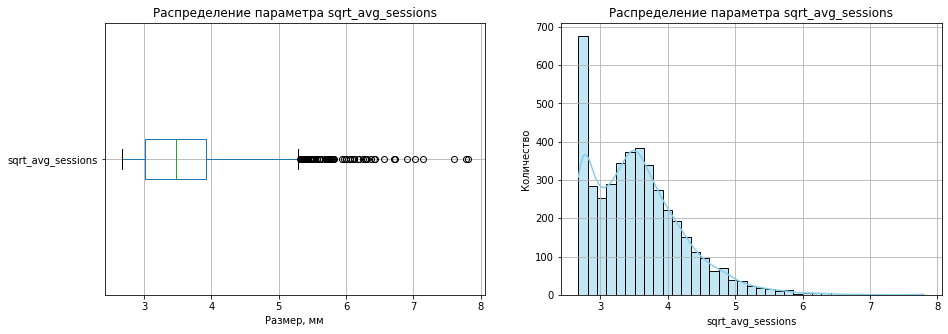

In [40]:
show_features_distribution(X_train_enhanced, ['sqrt_avg_sessions'])

Распределение стало более равномерным по сравнению с исходным признаком.

In [41]:
X_train_enhanced.head()

,daytime,website_category,ads_activity,surf_depth,primary_device,cloud_usage,sqrt_avg_sessions,daytime_device,mobile_cloud_user,is_active_ads_user,website_ads_interaction
5918,вечер,Category 04,редко,средне,смартфон,True,4.123106,вечер_смартфон,1,0,Category 04_редко
5236,день,Category 03,редко,поверхностно,смартфон,True,3.316625,день_смартфон,1,0,Category 03_редко
4297,день,Category 01,редко,поверхностно,смартфон,True,2.828427,день_смартфон,1,0,Category 01_редко
1568,вечер,Category 02,умеренно,средне,смартфон,True,3.515252,вечер_смартфон,1,1,Category 02_умеренно
1490,вечер,Category 18,очень редко,поверхностно,смартфон,False,3.105318,вечер_смартфон,0,0,Category 18_очень редко


Применим методы-обёртки для отбора признаков.

In [42]:
cat_features_enhanced = X_train_enhanced.select_dtypes(include=['object']).columns
target_cat_features_enhanced = target_cat_features + ['website_ads_interaction']
onehot_cat_features_enhanced = cat_features_enhanced.drop(target_cat_features_enhanced, errors='ignore').tolist()

num_features_enhanced = X_train_enhanced.select_dtypes(include=['int', 'float']).columns
num_features_enhanced = num_features_enhanced.drop(['age_category'], errors='ignore').tolist()

# Создаем ColumnTransformer
preprocessor_enhanced = build_preprocessor(onehot_cat_features_enhanced, target_cat_features_enhanced, num_features_enhanced)

X_train_enhanced_processed = preprocessor_enhanced.fit_transform(X_train_enhanced, y_train)
feature_names_enhanced = preprocessor_enhanced.get_feature_names_out()

In [43]:
# Инициализируем модель, которая будет использоваться для оценки важности признаков
lr_estimator = LogisticRegression(max_iter=1000, solver="lbfgs", penalty="l2", random_state=RANDOM_STATE)

# Создаём объект RFE
rfe_selector = RFE(lr_estimator, n_features_to_select=30)

# Обучаем RFE
rfe_selector.fit(X_train_enhanced_processed, y_train)

# Получаем информацию о выбранных признаках
rfe_selected_idx = rfe_selector.support_
selected_rfe_features = np.array(feature_names_enhanced)[rfe_selected_idx]

In [44]:
print('Выбранные признаки:')
selected_rfe_features.tolist()

Выбранные признаки:


['onehot_cat__daytime_вечер',
 'onehot_cat__daytime_день',
 'onehot_cat__daytime_утро',
 'onehot_cat__ads_activity_очень редко',
 'onehot_cat__ads_activity_очень часто',
 'onehot_cat__ads_activity_умеренно',
 'onehot_cat__ads_activity_часто',
 'onehot_cat__surf_depth_поверхностно',
 'onehot_cat__primary_device_ПК',
 'onehot_cat__primary_device_ноутбук',
 'onehot_cat__primary_device_планшет',
 'onehot_cat__primary_device_смартфон',
 'onehot_cat__cloud_usage_False',
 'onehot_cat__cloud_usage_True',
 'onehot_cat__daytime_device_вечер_планшет',
 'onehot_cat__daytime_device_вечер_смартфон',
 'onehot_cat__daytime_device_день_ПК',
 'onehot_cat__daytime_device_день_планшет',
 'onehot_cat__daytime_device_день_смартфон',
 'onehot_cat__daytime_device_утро_смартфон',
 'target_cat__website_category_0',
 'target_cat__website_category_1',
 'target_cat__website_category_2',
 'target_cat__website_category_3',
 'target_cat__website_category_4',
 'target_cat__website_ads_interaction_0',
 'target_cat__web

In [45]:
lr_pipeline_enhanced, lr_cv_results_enhanced = build_pipeline(X_train_enhanced, preprocessor_enhanced, lr, selected_rfe_features)

Посмотрим на метрики модели LogisticRegression с добавленными признаками.

In [46]:
print(f"F1: {lr_cv_results_enhanced['test_f1_macro'].mean():.4f}")
print(f"Precision: {lr_cv_results_enhanced['test_precision_macro'].mean():.4f}")
print(f"Recall: {lr_cv_results_enhanced['test_recall_macro'].mean():.4f}")
print()
print(f"Изменение метрики F1: {(lr_cv_results_enhanced['test_f1_macro'].mean() - lr_cv_results['test_f1_macro'].mean()):.4f}")
print(f"Изменение метрики Precision: {(lr_cv_results_enhanced['test_precision_macro'].mean() - lr_cv_results['test_precision_macro'].mean()):.4f}")
print(f"Изменение метрики Recall: {(lr_cv_results_enhanced['test_recall_macro'].mean() - lr_cv_results['test_recall_macro'].mean()):.4f}")

F1: 0.4845
Precision: 0.4840
Recall: 0.5009

Изменение метрики F1: 0.0019
Изменение метрики Precision: 0.0022
Изменение метрики Recall: 0.0017


После добавления новых признаков и отбора метрики улучшились но незначительно.

<span style="color: blue; font-weight: bold">Комментарий ревьюера : </span> ✔️\
<span style="color: green"> 👍</span>

## Подбор гиперпараметров моделей

Создадим сетку гиперпараметров для модели LogisticRegression и SVC моделей с учётом специфики ядер.

In [47]:
lr_param_grid = {
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'model__max_iter': [500, 1000, 5000],
    'model__tol': [1e-4, 1e-3, 1e-2]
}

svc_param_grid = [
    {
        "model__kernel": ["linear"],
        "model__C": [0.01, 0.1, 1],
        "model__class_weight": ['balanced']
    },
    {
        "model__kernel": ["poly"],
        "model__C": [0.01, 0.1, 1],
        "model__gamma": ["scale", "auto"],
        "model__degree": [2, 3, 4],
        "model__coef0": [0.0, 1.0],
        "model__class_weight": ['balanced']
    },
    {
        "model__kernel": ["rbf"],
        "model__C": [0.01, 0.1, 1],
        "model__gamma": ["scale", "auto"],
        "model__class_weight": ['balanced']
    },
    {
        "model__kernel": ["sigmoid"],
        "model__C": [0.01, 0.1, 1],
        "model__gamma": ["scale", "auto"],
        "model__coef0": [0.0, 1.0],
        "model__class_weight": ['balanced']
    }
]

Сделаем поиск лучших гиперпараметров.

In [48]:
lr_grid = GridSearchCV(
    estimator=lr_pipeline_enhanced,
    param_grid=lr_param_grid,
    cv=3,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

svc = SVC(class_weight='balanced', random_state=RANDOM_STATE)
svc_pipeline, svc_cv_results = build_pipeline(X_train_enhanced, preprocessor_enhanced, svc, selected_rfe_features)
svc_grid = GridSearchCV(
    estimator=svc_pipeline,
    param_grid=svc_param_grid,
    cv=3,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

Определим лучшие гиперпараметры.

In [49]:
lr_grid.fit(X_train_enhanced, y_train)

lr_best_params = lr_grid.best_params_
lr_best_params_clean = {k.replace('model__', ''): v 
                     for k, v in lr_best_params.items()}
lr_best_score = round(lr_grid.best_score_, 3)


svc_grid.fit(X_train_enhanced, y_train)

svc_best_params = svc_grid.best_params_
svc_best_params_clean = {k.replace('model__', ''): v 
                     for k, v in svc_best_params.items()}
svc_best_score = round(svc_grid.best_score_, 3)

print()
print("Лучшие гиперпараметры для LogisticRegression:", lr_best_params)
print("Лучший средний результат F1 на кросс-валидации для LogisticRegression:", lr_best_score)
print()
print("Лучшие гиперпараметры для SVC:", svc_best_params)
print("Лучший средний результат F1 на кросс-валидации для SVC:", svc_best_score)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Fitting 3 folds for each of 57 candidates, totalling 171 fits

Лучшие гиперпараметры для LogisticRegression: {'model__C': 10, 'model__max_iter': 1000, 'model__tol': 0.001}
Лучший средний результат F1 на кросс-валидации для LogisticRegression: 0.482

Лучшие гиперпараметры для SVC: {'model__C': 1, 'model__class_weight': 'balanced', 'model__kernel': 'linear'}
Лучший средний результат F1 на кросс-валидации для SVC: 0.471


Выведем топ-15 лучших гиперпараметров.

In [50]:
lr_results = pd.DataFrame(lr_grid.cv_results_)
svc_results = pd.DataFrame(svc_grid.cv_results_)

lr_results['source'] = 'lr'
svc_results['source'] = 'svc'

combined_results = pd.concat([lr_results, svc_results], ignore_index=True)

top_15 = combined_results.sort_values('mean_test_score', ascending=False).head(15)
top_15[['params', 'mean_test_score']]

,params,mean_test_score
40,"{'model__C': 10, 'model__max_iter': 1000, 'model__tol': 0.001}",0.482031
46,"{'model__C': 100, 'model__max_iter': 500, 'model__tol': 0.001}",0.481565
42,"{'model__C': 10, 'model__max_iter': 5000, 'model__tol': 0.0001}",0.481502
52,"{'model__C': 100, 'model__max_iter': 5000, 'model__tol': 0.001}",0.480106
37,"{'model__C': 10, 'model__max_iter': 500, 'model__tol': 0.001}",0.479657
39,"{'model__C': 10, 'model__max_iter': 1000, 'model__tol': 0.0001}",0.479465
51,"{'model__C': 100, 'model__max_iter': 5000, 'model__tol': 0.0001}",0.479326
33,"{'model__C': 1, 'model__max_iter': 5000, 'model__tol': 0.0001}",0.479238
36,"{'model__C': 10, 'model__max_iter': 500, 'model__tol': 0.0001}",0.479172
43,"{'model__C': 10, 'model__max_iter': 5000, 'model__tol': 0.001}",0.479156


<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'> Отлично, что есть табличка результатов для сравнения.</font>

## Подготовка артефактов модели для внедрения

In [51]:
final_model = LogisticRegression(solver="lbfgs", penalty="l2", random_state=RANDOM_STATE, **lr_best_params_clean)

final_pipeline, final_cv_results = build_pipeline(X_train_enhanced, preprocessor_enhanced, final_model, selected_rfe_features)
final_pipeline.fit(X_train_enhanced, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('onehot_cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['daytime', 'ads_activity',
                                                   'surf_depth',
                                                   'primary_device',
                                                   'cloud_usage',
                                                   'daytime_device']),
                                                 ('target_cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strateg...
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['sqrt_avg_sessions',
                                                   'mobile_cloud_user',
                                                   'is_active_ads_user'])])),
                ('selector',
                 FunctionTransformer(func=<function select_features at 0x7f2a0767da60>,
                                     kw_args={'indices': [0, 1, 2, 3, 4, 6, 7,
                                                          9, 11, 12, 13, 14, 15,
                                                          16, 19, 20, 21, 23,
                                                          24, 25, 26, 27, 28,
                                                          29, 30, 31, 32, 33,
                                                          34, 35]})),
                ('model',
                 LogisticRegression(C=10, max_iter=1000, random_state=42,
                                    tol=0.001))])

In [52]:
X_test_enhanced = create_enhanced_features(X_test)

y_pred = final_pipeline.predict(X_test_enhanced)
print("F1:", round(f1_score(y_test, y_pred, average="macro"), 2))
print(classification_report(y_test, y_pred))

F1: 0.43
              precision    recall  f1-score   support

           0       0.50      0.59      0.54       268
           1       0.19      0.03      0.05       161
           2       0.48      0.57      0.52       459
           3       0.38      0.28      0.32       392
           4       0.65      0.76      0.70       564

    accuracy                           0.52      1844
   macro avg       0.44      0.45      0.43      1844
weighted avg       0.49      0.52      0.49      1844



F1 = 0.45 - низкий средний результат.

<font color='blue'><b>Комментарий ревьюера: </b></font> ❌\
<font color='red'> К сожалению, Лучшая из моделей не показала результат выше 0.75 F1-меры macro на тестовых данных.</font>
> Значение F1-меры лучшей модели должно быть не меньше 0.75 и на кросс-валидации по обучающей выборке, и на тестовой выборке. В этом случае модель можно рекомендовать к внедрению.

<span style="color: purple; font-weight: bold">Комментарий студента</span>:<br />
Можешь подсказать какие еще шаги можно предпринять для повышения. Я пробовал еще добавлять разные признаки, результат примерно такой же остается.

Сохраним итоговую модель и пайплайн предобработки в файл final_model.joblib.

In [53]:
joblib.dump(final_pipeline, 'final_model.joblib')

['final_model.joblib']

Протестируем сохраненную модель. Загрузим файл и проверим загруженную модель на тестовых данных.

In [54]:
# Загрузим модель из файла 'final_model.joblib' в переменную loaded_model
loaded_model = joblib.load('final_model.joblib')

# Получаем предсказание
prediction = loaded_model.predict(X_test_enhanced)
prediction_proba = loaded_model.predict_proba(X_test_enhanced)

print(prediction)
prediction_proba

[0 0 0 ... 3 0 3]


array([[0.71542253, 0.07149652, 0.06763291, 0.0935304 , 0.05191764],
       [0.7128052 , 0.18791353, 0.05810434, 0.01885351, 0.02232343],
       [0.63601325, 0.16743231, 0.15272786, 0.02995336, 0.01387323],
       ...,
       [0.12474554, 0.03805284, 0.28938381, 0.42317273, 0.12464508],
       [0.64070002, 0.13806186, 0.03792325, 0.15876032, 0.02455455],
       [0.02359305, 0.0990102 , 0.23717309, 0.32101684, 0.31920681]])

Сохраним функцию для объединения данных.

In [56]:
joblib.dump(combine_data, 'combine_data_function.joblib')

['combine_data_function.joblib']

Протестируем сохраненную функцию.

In [57]:
new_df = combine_data(ds_s13_users_df, ds_s13_visits_df, ads_activity_df, surf_depth_df, primary_device_df, cloud_usage_df)

In [59]:
new_df.head()

,user_id,age_category,daytime,website_category,avg_sessions_per_day,ads_activity,surf_depth,primary_device,cloud_usage
0,f545-8c95aefe8d3e5548a689-a5b2fd39,4,день,Category 05,13.714000,NaN,глубоко,смартфон,False
1,cb48-5a0d6cde4d86ae10637e-c8ceb6ed,2,вечер,Category 03,10.286000,умеренно,средне,смартфон,False
2,678b-614cd47d854b9d591db2-000b2e50,0,вечер,Category 12,7.286000,умеренно,средне,смартфон,False
3,4ac0-dad169100b4a29b20818-b26ae7c5,4,день,Category 18,18.071000,редко,поверхностно,смартфон,True
4,f19b-9ac21ca973b41ecfa8c3-6a58191d,0,вечер,Category 12,8.714000,очень редко,поверхностно,смартфон,True


<span style="color: blue; font-weight: bold">Комментарий ревьюера : </span>  ❌\
<span style="color: red"> В этом проекте нужно сохранить не только предобработку данных для модели, но и подготовку данных для модели: Нужна функция (класс) которая из 5 таблиц возвращает данные которые можно подавать в Пайплайн (`df`)</span>
> Иными словами, если вы используете перед пайплайном с моделью отдельную функцию для объединения датафреймов и создания признаков, то не забудьте сохранить в отдельный файл и эту функцию. Без неё внедрение модели в эксплуатацию будет невозможно.

<span style="color: purple; font-weight: bold">Комментарий студента</span>:<br />
Спасибо, добавил.

## Выводы о результатах работы

Модель демонстрирует среднее общее качество (F1=0.45), но с сильной вариацией по классам. Хорошо распознается класс 4 (F1=0.74), удовлетворительно — классы 0 и 2 (F1=0.57 и 0.52), плохо — класс 3 (F1=0.35) и критически плохо — класс 1 (F1=0.07).
Основная проблема — дисбаланс классов и недостаточное качество для классов с малым количеством примеров. Модель нуждается в доработке, особенно для малых классов. Требуется балансировка данных.

### Рекомендации

- балансировка классов;
- улучшение признакового пространства;
- увеличение выборки для малых классов;

<font color='blue'><b>Комментарий ревьюера : </b></font> ✔️\
<font color='green'> Очень приятно видеть вывод в конце проекта!\
Приведены ответы на главные вопросы проекта.</font>

Cсылка на репоизиторий https://github.com/alexilin83/ds_sprint_13

<font color='blue'><b>Итоговый комментарий ревьюера</b></font>\
<font color='green'>Алексей, хороший проект получился!
Большое спасибо за проделанную работу. Видно, что приложено много усилий.
Выводы и рассуждения получились содержательными, их было интересно читать.
</font>

<font color='steelblue'>Над проектом ещё стоит поработать - есть рекомендации по дополнению некоторых твоих шагов проекта. Такие рекомендации я отметил жёлтыми комментариями. Будет здорово, если ты учтёшь их - так проект станет структурно и содержательно более совершенным.

Также в работе есть критические замечания. К этим замечаниям я оставил пояснительные комментарии красного цвета, в которых перечислил возможные варианты дальнейших действий. Уверен, ты быстро с этим управишься:)

Если о том, что нужно сделать в рамках комментариев, будут возникать вопросы - оставь их, пожалуйста, в комментариях, и я отвечу на них во время следующего ревью.

Также буду рад ответить на любые твои вопросы по проекту или на какие-либо другие, если они у тебя имеются - оставь их в комментариях, и я постараюсь ответить:)</font>

<font color='blue'><b>Жду твой проект на повторном ревью. До встречи :) </b></font>